In [1]:
# IMPORTS
from routing import TaxiRouting, create_dataframes
import numpy as np
import pandas as pd
import random
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

# Min-Cost Flow Lab

**Objectives:**

* Understand the min-cost flow problem.
* Use the min-cost flow problem to solve the shortest path problem.
* Apply min-cost flow to the taxi-routing problem.
* Analyze solutions to the taxi-routing problem
    
<font color='red'> **Instructor Comments** </font>

<font color='blue'> **Solutions** </font>

**Review:** Recall the min-cost flow problem. For our input, we have a directed graph $G = (N,A)$. For each arc $(i,j) \in A$, we have a per-unit cost $c(i,j)$ and capacity $u(i,j)$. For each node $i \in N$, we have a demand / supply $s(i)$. If $s(i) > 0$, we have supply at node $i$. If $s(i) < 0$, we have demand at node $i$. Our goal is to distribute the supply from supply nodes to the demand nodes at minimal cost. A solution to the min-cost problem can be described by a giving a flow $f(i,j)$ for every arc $(i,j) \in A$. The objective value of a solution is given by $\sum_{(i,j) \in A} c(i,j)*f(i,j)$.

## Part 1: A Little Theory

**Q1:** What must be true for there to be an optimal solution? (Hint: supply and demand)

**A:** <font color='blue'> The total supply must be greater or equal to the total demand.</font>

**Q2:** Consider a cut $S \subset N$ on the graph $G = (N,A)$. The capacity of a cut $S$ is the sum of capacities of all edges $(i,j)$ where $i \in S$ and $j \in T = N \setminus S$ (the notation $A \setminus B$ means all the elements of $A$ that are not in $B$). Notationally, the capcity of cut $S$ is $$\sum_{(i,j) \in A \mid i \in S, j \in T}u(i,j).$$ Let the total demand and total supply in set $T$ be denoted $d_T$ and $s_T$ respectively. Assume $d_T > s_T$. Hence, the total supply within the set $T$ is not enough to satisfy the demand within set $T$. If we asssume this instance has a feasible solution, what must be true about the capacity of the cut $S$.


**A:** <font color='blue'>The flow into set $T$ must be at least $d_T - s_T$ in order to satisfy the demand in set $T$. Hence, the capacity of the cut $S$ must be at least $d_T - s_T$.</font>

Recall the shortest path problem. We have a directed graph $G = (N,A)$ with length $\ell(i,j)$ for all edges $(i,j) \in A$ and source/sink $s,t \in N$. Our goal is to find an $s-t$ path of minimum length. How could we use the min-cost flow problem to solve the shortest path problem? Let's walk through the formulation.

**Q3:** Let's use the input directed graph $G = (N,A)$ for the shortest path problem as our directed graph for our min-cost flow problem. We need to assign a cost $c(i,j)$ for all edges $(i,j) \in A$. What should the cost be?

**A:** <font color='blue'>$c(i,j) = \ell(i,j)$</font>

**Q4:** We also need to assign a capacitiy $u(i,j)$ for all edges $(i,j) \in A$. What should the capacity be?

**A:** <font color='blue'>$u(i,j) = 1$</font>

**Q5:** Lastly, we need to asssign supply/demand $s(i)$ to every node $i \in N$. What should the supply/demands be?

**A:** <font color='blue'>$s(s) = 1$, $s(t) = -1$, and $s(i) = 0$ otherwise.</font>

If you are unsure about your formulation, reach out to a TA before heading on!

The following will be a little hand-wavy. Let's say we have a black box that solves min-cost flow problems. Given all the inputs, it returns an optimal solution $f(i,j)$ for all $(i,j) \in A$. If all $u(i,j)$ and $s(i)$ are integral, the **integrality property** states that the black-box will return an all integral solution.

**Q6:** If $0 \leq x \leq 1$ and $x$ is integral, what values can $x$ be?

**A:** <font color='blue'> Either $x = 1$ or $x = 0$</font>

**Q7:** What does the integrality property and your answer to Q6 imply about the optimal solution that will be returned when using the black-box to solve the min-cost flow input created to solve the shortest path problem?

**A:** <font color='blue'>The optimal solution will be integral. Furthermore, since $0 \leq f(i,j) \leq 1$, we know that $f(i,j)$ will be 1 or 0. </font>

**Q8:** How can we interpret a min-cost flow solution as a solution to the shortest path problem.

**A:** <font color='blue'>If $f(i,j) = 1$, then $(i,j)$ is in the path. Otherwise, it is not. </font>

You are now very familiar with the steps required to show how one problem can be used to solve another. At this point, we have done the first step: created a way to transform shortest-path inputs into min-cost flow inputs. The remaining steps are to show there is a one-to-one correspondence between feasible solutions to the shortest-path problem and feasible solutions to the min-cost flow problem and show the objective values are the same (or differ by a constant). Think about how this argument might look. The next question addresses one complication you will come across.

Suppose we have the following graph for the shortest path problem. 

![](graph.png)

Consider the feasible solution to the min-cost flow problem where $f(i,j) = 1$ for edges $(1,2),(2,3),(3,5),(5,2),(2,4),$ and $(4,6)$

**Q9:** Does this feasible solution correspond to an $s-t$ path? Why or why not?

**A:** <font color='blue'>No because (2,3),(3,5), and (5,2) form a cycle. </font>

**Q10:** Does the feasible solution **contain** an $s-t$ path? If so, what is it?

**A:** <font color='blue'>Yes, (1,2),(2,4),(4,6) is an $s-t$ path. </font>

**Q11:** How did you arrive at an $s-t$ path?

**A:** <font color='blue'> Cut out the cycle. </font>

**Q12:** Consider any feasible solution to the min-cost flow problem that corresponds to a path that has some cycles. If we cut out the cycles to obtain a corresponding $s-t$ path, how will the cost of the min-cost flow solution correspond to the length of the corresponding $s-t$ path.

**A:**  <font color='blue'> The length of the $s-t$ path will always be shorter. </font>

## Part 2: The Taxi-Routing Problem

Suppose we are a New York City taxi company and we know all the ride requests we will receive over some time horizon. Each trip has a start/end location, start time, trip time, and some value. We could view the value as the revenue generated, number of passengers, or constant across all rides. Furthermore, we know the number of taxi cabs we have $B$ and the layout of Manhattan. We can represent Manhattan as a grid where every street intersection is a node and every street segment is an edge. Assume we also know the time it takes to traverse any street segment. We want to maximize the value of the trips we pick-up. Let's use the min-cost flow problem to solve this problem!

First, we must construct an input to the min-cost flow problem. Let us discretize time into minutes. We will have a time horizon of $T$ minutes. Next, let's index every location node so that we have $L$ nodes indexed $0,\dots,L-1$ for all $L$ locations in Manhattan. We now construct the directed graph $G$ that will be the input to the min-cost flow problem. There is a node for every time and location combination where node $(\ell,t)$ is the node representing location $\ell$ at time $t$.

Furthermore, we will have nodes $s$ and $f$. There is an edge from $s$ to node $(\ell,0)$ for all locations and an edge from node $(\ell,T)$ to $f$ for all locations. The idea is that a unit of flow through the graph will represent where a given taxi is at any given time over the time horizon.

**Q13:** What should the supplies for the $s$, $f$, and $(\ell,t)$ nodes be?

**A:** <font color='blue'> The supply at $s$ is $B$, the supply at any $(\ell,t)$ is 0, and the supply at $f$ is $-B$. </font>

We are almost there! We need to define the other edges in the graph and determine the cost and capacity for each edge. Since we know the layout of Manhattan, we know how long it takes to get from one location to another. In other words, we have a list of arcs of the form $(a,b,d)$ where $a$ is the start location, $b$ is the end location , and $d$ is the time it takes to travel between the two locations. For each arc of this type we will introduce edges from $(a,t)$ to $(b,t+d)$ for every $t$ such that $0 \leq t$ and $t+d \leq T$. Each edge of this type will have a capacity of $B$ because any taxi can traverse this edge and cost 0 since it is of zero value to drive with no passengers. Most importantly, we need edges to represent each trip we could take. Lastly, we need arcs to represent each trip.

**Q14:** Suppose we have a trip from location $a$ to $b$ that starts as time $t$ with duration $d$ and value $v$. What edge should be added and what are its cost and capacity?

**A:** <font color='blue'> We should have an edge from $(a,t)$ to $(b,t+d)$ with cost $-v$ and capacity 1. </font>

Let's look at a small input!

In [2]:
# start, end, start_time, trip_time, value
trips = [(2,1,1,2,1),
         (0,1,0,1,1),
         (0,1,2,1,1)]

# start, end, trip_time
arcs = []

B = 2  # number of taxis
L = 3  # of locations
T = max(np.array(list(zip(*trips))[2]) + np.array(list(zip(*trips))[3]))  # time horizon

trips_df, nodes_df, arcs_df = create_dataframes(trips, arcs, L)
small_ex = TaxiRouting(trips_df, nodes_df, arcs_df, 0, T, B)

Let's look at the corresponding min-cost flow input to this problem. The label on each edge is the flow on that edge.

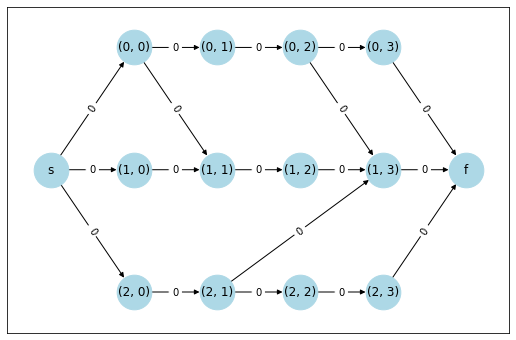

In [3]:
small_ex.draw_graph()

**Q14:** Is this what you expected? If not, why?

**A:** <font color='blue'> Depends. </font>

**Q15:** The edges $(\ell,t)$ to $(\ell,t+1)$ for all locations $\ell$ and $0 \leq t \leq T-1$ are automatically added to the graph despite being explicitly defined. What do they represent?

**A:** <font color='blue'> Staying at the same location. </font>

We can now solve the problem and look at the optimal flow again.

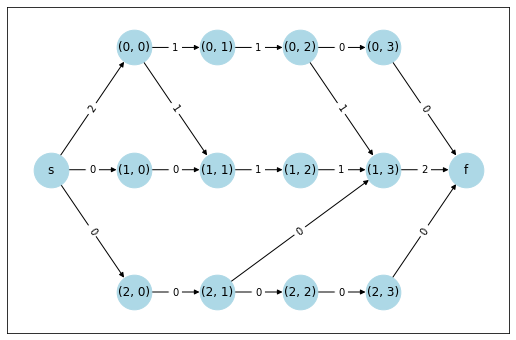

In [4]:
small_ex.optimize()
small_ex.draw_graph()

**Q16:** What is the cost of this solution? Recall that we used a constant value of 1 for each trip

**A:** <font color='blue'> -2 because we satisfied 2 trips. </font>

**Q17:** Intepret this solution as a solution to the taxi-routing problem. That is, give a schedule for every taxi.

**A:** <font color='blue'> One taxi starts at location 0 and takes a trip from location 0 to 1. After that, they stay at location 1 for the rest of the time horizon. The other taxi starts at location 2 and waits until $t = 1$ to take a trip from location 2 to 1. </font>     

**Q18:** We have a trip from location 0 to 1 that only takes 1 minute. Suppose this takes a two way road and we can get from location 1 to 0 in 1 minute as well. Add this to the input and see how the optimal solution changes.

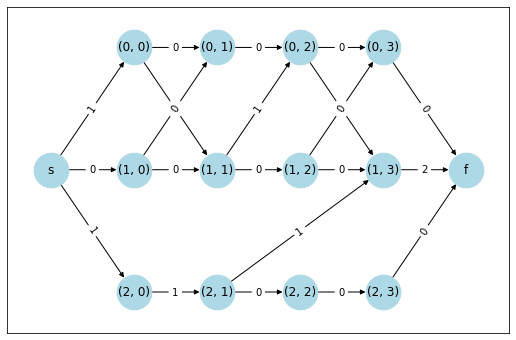

In [5]:
# start, end, trip_time
arcs = [] # ADD YOUR ANSWER HERE

# SOLUTION
arcs = [(1,0,1)]

trips_df, nodes_df, arcs_df = create_dataframes(trips, arcs, L)
small_ex = TaxiRouting(trips_df, nodes_df, arcs_df, 0, T, B)
small_ex.optimize()
small_ex.draw_graph()

It becomes hard to interpret the solution with so many edges. We can use the following command to get the taxi paths:

In [6]:
paths = small_ex.taxi_paths()

This returns a list of paths for each taxi. Let's look at the first taxi.

In [7]:
paths[0]

[(0, 1, True), (1, 0, False), (0, 1, True)]

We can intepret this output as follows: This taxi went from location 0 to 1 taking a trip then went back to location 0 without taking a trip before taking another trip from location 0 to 1.

**Q19:** Interpret the path of the other taxi.

In [8]:
paths[1]

[(2, 2, False), (2, 1, True)]

**A:** <font color='blue'> This taxi stayed at location 2 then took a trip from location 2 to 1.</font>

## Part 3: The Taxi-Routing Problem (At Scale)

Let's look at the taxi routing problem at scale! First, we need to input some data:

In [9]:
trips_df = pd.read_csv('data/2013-09-01_trip_data_manhattan.csv').drop(columns='id')
trips_df['revenue'] = 2.50 + 1.56*trips_df.trip_distance + 0.50*trips_df.trip_time
trips_df.revenue = trips_df.revenue.apply(lambda x: round(x,2))

nodes_df = pd.read_csv('data/nyc_nodes_manhattan.csv').drop(columns='Unnamed: 0')
arcs_df = pd.read_csv('data/nyc_links_manhattan.csv').drop(columns='Unnamed: 0')

**Q20:** Take a look at the 3 dataframes.

In [10]:
trips_df.head()

,start_node,end_node,start_time,trip_time,passenger_count,trip_distance,revenue
0,333,692,0,6,5,2.204796,8.94
1,1802,110,0,7,1,1.738087,8.71
2,1769,77,0,9,1,5.262542,15.21
3,526,2573,0,18,5,2.687598,15.69
4,148,2662,0,32,5,13.067841,38.89


In [11]:
nodes_df.head()

,name,lon,lat,x,y
0,0,-74.003837,40.710545,-8.238069e+06,4.969740e+06
1,1,-73.969571,40.749594,-8.234255e+06,4.975477e+06
2,2,-73.964442,40.753157,-8.233684e+06,4.976000e+06
3,3,-74.012328,40.713941,-8.239015e+06,4.970239e+06
4,4,-74.008254,40.736961,-8.238561e+06,4.973621e+06


In [12]:
arcs_df.head()

,start,end,street_name,trip_time
0,598,597,MadisonAvenue,1
1,103,597,East60thStreet,1
2,599,598,MadisonAvenue,1
3,1152,598,East59thStreet,1
4,601,600,MadisonAvenue,1


**Q21:** The `trips_df` dataframe has a list of trips but is missing a field for value. If we want to create a taxi schedule maximizing revenue, what should be the value for each trip?

**A:** <font color='blue'> The value of each trip should be the revenue that trip generates.</font>

**Q22:** The following code creates a feild in `trips_df` called `value` and sets it equal to another field in the dataframe. Fill in the missing field name based on your answer to Q21 then run the next line to make sure the field was added properly.

In [13]:
#trips_df['value'] = trips_df['FIELD']  # replace FIELD

# SOLUTION
trips_df['value'] = trips_df['revenue']

In [14]:
trips_df.head()

,start_node,end_node,start_time,trip_time,passenger_count,trip_distance,revenue,value
0,333,692,0,6,5,2.204796,8.94,8.94
1,1802,110,0,7,1,1.738087,8.71,8.71
2,1769,77,0,9,1,5.262542,15.21,15.21
3,526,2573,0,18,5,2.687598,15.69,15.69
4,148,2662,0,32,5,13.067841,38.89,38.89


We can now pass this input to the TaxiRouting solver! In `trips_df`, the `start_time` field is given in minutes since midnight. Let's first look at the time window of 5:00 PM to 5:15 PM. This corresponds to 1020 to 1035. Furthermore, we will have 500 taxis on the road.

In [15]:
nyc_taxi = TaxiRouting(trips_df, nodes_df, arcs_df, 1020, 1035, 500)

Now let's solve it and print some statistics about the solution.

In [16]:
nyc_taxi.optimize()
nyc_taxi.get_stats()

Summary Statistics
Avg. Moving Pct.:  0.83
Avg. On Trip Pct.:  0.61
Avg. Total Distance of Trips:  3.16
Avg. Revenue:  12.64
Total Trips:  628 ( 0.79 )
Total Passengers:  1182 ( 0.78 )
Total Revenue:  6319.47 ( 0.86 )


It turns out 500 taxis was not enough to get all the requested rides in this time period. The percent of potential trips, passengers, and revenue that were acheived are given in the parentheses following the corresponding statisitc (ex. there were 792 trips that could have been taken but only 628 or 79% were). 

Furthermoe, here is a quick description of each statisitcic:

* **Average Moving Percentage:** The moving percentage for a taxi is the percent of time intervals the taxi is moving from one location to another (it may or may not have a passenger). This is the average moving percentage across all taxis.
* **Average On Trip Percentage:** The on trip percentage for a taxi is the percent of time intervals the taxi has a passenger. This is the average on trip percentage across all taxis.
* **Average Total Distance of Trips:** The total distance travelled during trips is computed for each taxi and them averaged.
* **Average Revenue:** Average revenue collected per taxi cab.
* **Total Trips:** Total number of trips the taxi routing schedule could accommodate.
* **Total Passengers:** Total number of passengers the taxi routing schedule could accommodate.
* **Total Revenue:** Total revenue generated from the taxi routing schedule.

To look at the statistics for an indiviual taxi, we use the following command where the index is the id of the taxi.

In [17]:
nyc_taxi.taxi_stats[12]

{'moving_pct': 0.9333333333333333,
 'on_trip_pct': 0.4666666666666667,
 'num_trips': 1,
 'total_trip_distance': 2.0760486,
 'total_passengers': 1,
 'revenue': 9.24}

We can also plot the path of a set of taxis! The path of each taxi is color-coded. The circle represents its start location and the lower opacity edges indicate the taxi has a passenger.

In [18]:
nyc_taxi.plot_taxi_route([12])

**Q23:** What if we wanted to maximize the number of passengers we accommodated instead of maximizing revenue? How would we change the value? Adjust the value field accordingly.

In [19]:
# trips_df['value'] = # FINISH THIS

#SOLUTION
trips_df['value'] = trips_df['passenger_count']

**Q24:** What was the total revenue generared in the previous solution where we tried to maximize revenue. How many passengers were accommodated? Before re-solving with a new objective, what do you know already know about the these values in the new solution? (Hint: How can you bound these values?)

**A:** <font color='blue'> The revenue was 6319.47 and the number of accommodated passengers was 1182. In the new solution, the revenue must be $\leq 6319.47$ and the number of passengers must be $\geq 1182$. </font>

In [20]:
nyc_taxi = TaxiRouting(trips_df, nodes_df, arcs_df, 1020, 1035, 500)
nyc_taxi.optimize()
nyc_taxi.get_stats()

Summary Statistics
Avg. Moving Pct.:  0.84
Avg. On Trip Pct.:  0.5
Avg. Total Distance of Trips:  2.62
Avg. Revenue:  10.96
Total Trips:  628 ( 0.79 )
Total Passengers:  1345 ( 0.89 )
Total Revenue:  5482.12 ( 0.74 )


**Q25:** On average, what was the total distance a taxi drove on a trip in the previous solution (maximizing revenue). What about the new solution (maximizing passengers)? How do these values compare? Why might this be?

**A:** <font color='blue'> Before, it was 3.16. Now, it is 2.62. It is much less in this solution. It looks like most taxis will only make one ride in this 15 minute time span. The longer the ride, the higher the revenue will be. Since revenue and trip distance are correlated, the trip distance will naturally be pretty high when we maximize revenue. However, the trip distance is not correlated with number of passengers so it is not weighted in the objective function. This leads to a lower value in the new solution.</font>

**Q26:** Lastly, what if we wanted to maximize the number of trips. How would we change the value? Adjust the value field accordingly.

In [21]:
# trips_df['value'] = # FINISH THIS

#SOLUTION
trips_df['value'] = 1

In [22]:
nyc_taxi = TaxiRouting(trips_df, nodes_df, arcs_df, 1020, 1035, 500)
nyc_taxi.optimize()
nyc_taxi.get_stats()

Summary Statistics
Avg. Moving Pct.:  0.85
Avg. On Trip Pct.:  0.5
Avg. Total Distance of Trips:  2.6
Avg. Revenue:  10.97
Total Trips:  628 ( 0.79 )
Total Passengers:  1187 ( 0.79 )
Total Revenue:  5483.29 ( 0.74 )


To finish, let's look over a wider time horizon. Since we were only looking at a 15 minute interval before, each taxi only had 1 ride on average. This is more of an assignment problem of taxis to rides and does not capture the full complexity of a schedule with taxis striningly together multiple rides. Let's look at 5:00 PM to 6:30 PM with 1500 taxis now. We will return to our revenue maximizing objective.

Run the cell below to compute the taxi schedule. (Note, this takes a bit (about 2 minutes). The corresponding min-cost flow formulation has 278,735 nodes and 855,945 edges!)

In [23]:
trips_df['value'] = trips_df['revenue']
nyc_taxi = TaxiRouting(trips_df, nodes_df, arcs_df, 1020, 1110, 1500)
nyc_taxi.optimize()
nyc_taxi.get_stats()

Summary Statistics
Avg. Moving Pct.:  0.88
Avg. On Trip Pct.:  0.65
Avg. Total Distance of Trips:  19.06
Avg. Revenue:  73.6
Total Trips:  8806 ( 0.91 )
Total Passengers:  16210 ( 0.91 )
Total Revenue:  110395.53 ( 0.93 )


**Q27:** How many rides does each taxi make on average?

**A:** <font color='blue'> There are 1500 taxis and 8806 rides made so 5.87 $\approx$ 6 rides per taxi</font>

Let's look at a few random taxi paths in this solution.

In [24]:
random.seed(1101)  # set random seed
taxis = [random.randint(0,1500) for i in range(3)]
nyc_taxi.plot_taxi_route(taxis)

These taxis make a total of 16 trips.


**Q28:** What does the solution maximizing the number of trips look like? Run the code to change the objective (change the value field), create the new problem, solve it, and print the summary statisitcs.

In [25]:
trips_df['value'] = 1
nyc_taxi = TaxiRouting(trips_df, nodes_df, arcs_df, 1020, 1110, 1500)
nyc_taxi.optimize()
nyc_taxi.get_stats()

Summary Statistics
Avg. Moving Pct.:  0.87
Avg. On Trip Pct.:  0.62
Avg. Total Distance of Trips:  17.99
Avg. Revenue:  70.86
Total Trips:  9047 ( 0.93 )
Total Passengers:  16651 ( 0.93 )
Total Revenue:  106296.49 ( 0.89 )


In [26]:
nyc_taxi.plot_taxi_route(taxis)

These taxis make a total of 16 trips.


**Q29:** Visually compare the paths of the three taxis in the two different solutions. What do you notice? Try to give some explanation.

**A:** <font color='blue'>It appears the taxis do not cover as much ground as they did previously. They stay in one region as opposed to jumping all over the map. Recall that the solution maximizing revenue tends to have longer trips than the solution maximizing trips. Since the trips are shorter and taxis are unlikely to get multiple trips headed in the same direction, this leads to taxis covering smaller regions. </font>

**Bonus:** Play around with other objectives, time windows, number of taxis, etc. Use the summary statistics and path plotting functionalities to compare their solutions. What types of things did you notice? Was it what you expected? If you find something interesting, feel free to share!